# 3.6 Predicting house prices: a regression example

## 3.6.1 The Boston Housing Price dataset

In [1]:
from tensorflow.keras.datasets import boston_housing

# Importing the data to training and testing sets
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
# Checking the shape of the data
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [3]:
# Targets are home prices in thousands of dollars (from the 1970s)
train_targets[:3]

array([15.2, 42.3, 50. ])

## 3.6.2 Preparing the data

In [4]:
# Normalizing the data for the neural network
mean = train_data.mean(axis = 0)
train_data -= mean

std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

## 3.6.3 Building your network

In [5]:
from keras import models, layers

In [6]:
# Building a small network to prevent overfitting
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

## 3.6.4 Validation your approach using K-folds validation

In [7]:
import numpy as np

# Perform a test of k-fold cross validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f'Processing Fold #{i+1}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data  = np.concatenate(
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]], 
        axis = 0 )
    
    partial_train_targets  = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]], 
        axis = 0)
    
    model = build_model()
    
    model.fit(partial_train_data, partial_train_targets, 
              epochs = num_epochs, batch_size = 1, verbose=False)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=False)
    
    all_scores.append(val_mae)

Processing Fold #1
Processing Fold #2
Processing Fold #3
Processing Fold #4


In [8]:
all_scores

[1.9999395608901978, 2.9141619205474854, 2.5237762928009033, 2.259720802307129]

In [9]:
np.mean(all_scores)

2.424399644136429

In [10]:
# Perform a 500 epoch of k-fold cross validation
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f'Processing Fold #{i+1}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data,
                       partial_train_targets,
                       validation_data=(val_data,val_targets),
                       epochs=num_epochs,
                       batch_size=1,
                       verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold #1
Processing Fold #2
Processing Fold #3
Processing Fold #4


In [11]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

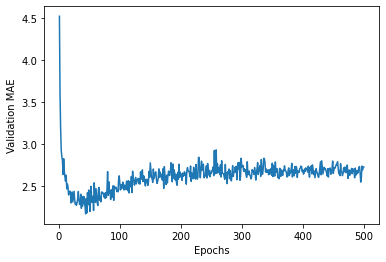

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

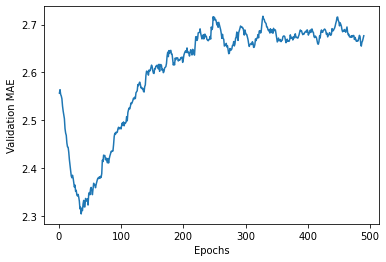

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
model = build_model()
model.fit(train_data,
         train_targets,
         epochs=80,
         batch_size=16,
         verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 1s 4ms/step - loss: 19.2182 - mae: 2.7113


In [15]:
test_mae_score

2.7113044261932373